## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.se/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.se/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.se/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.se/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [2]:
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from scipy.optimize import fsolve
from scipy.integrate import simpson
from scipy.integrate import odeint

from const import *
import ldf
import plotting
import method

importlib.reload(plotting)
importlib.reload(ldf)
importlib.reload(method)

<module 'method' from 'c:\\Users\\GUNU\\PythonProjects\\negative-ion\\method.py'>

In [4]:
ldf_list

[]

./211216(SF6)/bias (float) 56mm B-field/40.ldf


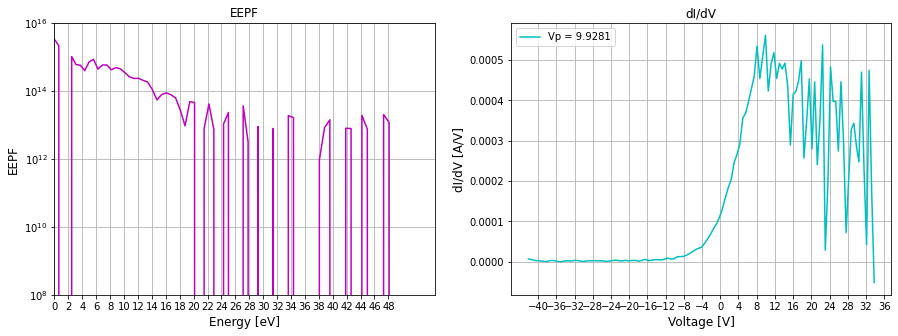

Enter limited energy
ne: 7.969e+15 [m-3]	 Te: 15.390 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2335	 gamma: 153.8990	 sol_number: 2
J: 7.14e+01	 uB: 622.681	 r_sh: 2.15e-04	
-------------------------------------------------------
a_0: 148.9469	 a_s: 0.0611	 gamma: 153.8990	 sol_number: 2
J: 3.32e+01	 uB: 1088.208	 r_sh: 2.70e-04	
-------------------------------------------------------
a_0: 38.8556	 a_s: 0.0803	 gamma: 153.8990	 sol_number: 2
J: 2.64e+01	 uB: 968.987	 r_sh: 2.84e-04	
-------------------------------------------------------
a_0: 34.6564	 a_s: 0.0825	 gamma: 153.8990	 sol_number: 2
J: 2.51e+01	 uB: 957.909	 r_sh: 2.88e-04	
-------------------------------------------------------
a_0: 33.3099	 a_s: 0.0833	 gamma: 153.8990	 sol_number: 2
J: 2.48e+01	 uB: 953.985	 r_sh: 2.89e-04	
-------------------------------------------------------
a_0: 33.0225	 a_s: 0.0835	 gamma: 153.8990	 sol_number: 2
J: 2.48e+01	 uB: 953.012	 r_sh: 2.89e-04	
-----------------------------------------------

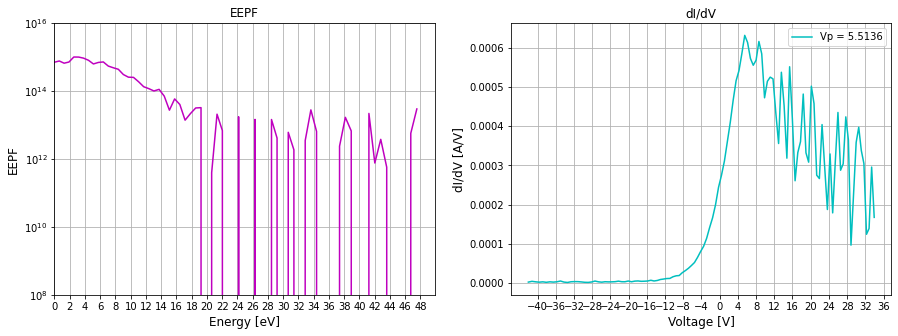

Enter limited energy
ne: 7.401e+15 [m-3]	 Te: 12.590 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.229	 gamma: 125.9020	 sol_number: 2
J: 7.43e+01	 uB: 625.539	 r_sh: 2.13e-04	
-------------------------------------------------------
a_0: 166.2072	 a_s: 0.058	 gamma: 125.9020	 sol_number: 2
J: 3.49e+01	 uB: 1100.169	 r_sh: 2.67e-04	
-------------------------------------------------------
a_0: 43.5964	 a_s: 0.0761	 gamma: 125.9020	 sol_number: 2
J: 2.79e+01	 uB: 982.825	 r_sh: 2.80e-04	
-------------------------------------------------------
a_0: 38.8980	 a_s: 0.0782	 gamma: 125.9020	 sol_number: 2
J: 2.65e+01	 uB: 971.718	 r_sh: 2.84e-04	
-------------------------------------------------------
a_0: 37.4261	 a_s: 0.0789	 gamma: 125.9020	 sol_number: 2
J: 2.62e+01	 uB: 968.108	 r_sh: 2.84e-04	
-------------------------------------------------------
a_0: 37.1040	 a_s: 0.0791	 gamma: 125.9020	 sol_number: 2
J: 2.61e+01	 uB: 967.085	 r_sh: 2.85e-04	
-------------------------------------------------

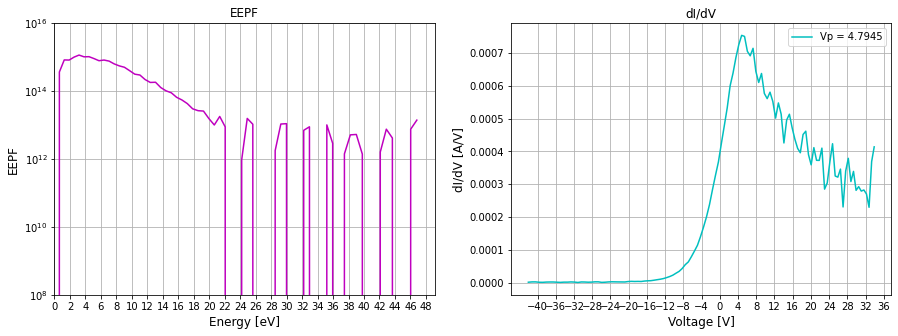

Enter limited energy
ne: 8.586e+15 [m-3]	 Te: 14.074 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2316	 gamma: 140.7368	 sol_number: 2
J: 8.22e+01	 uB: 623.884	 r_sh: 2.08e-04	
-------------------------------------------------------
a_0: 158.9234	 a_s: 0.0596	 gamma: 140.7368	 sol_number: 2
J: 3.95e+01	 uB: 1094.688	 r_sh: 2.58e-04	
-------------------------------------------------------
a_0: 42.7332	 a_s: 0.0777	 gamma: 140.7368	 sol_number: 2
J: 3.18e+01	 uB: 979.122	 r_sh: 2.70e-04	
-------------------------------------------------------
a_0: 38.4648	 a_s: 0.0796	 gamma: 140.7368	 sol_number: 2
J: 3.04e+01	 uB: 969.188	 r_sh: 2.73e-04	
-------------------------------------------------------
a_0: 37.0864	 a_s: 0.0803	 gamma: 140.7368	 sol_number: 2
J: 3.01e+01	 uB: 965.612	 r_sh: 2.74e-04	
-------------------------------------------------------
a_0: 36.8025	 a_s: 0.0805	 gamma: 140.7368	 sol_number: 2
J: 3.00e+01	 uB: 964.599	 r_sh: 2.74e-04	
-----------------------------------------------

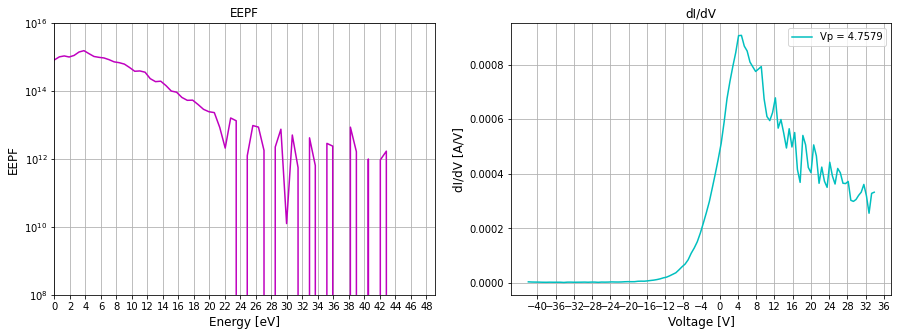

Enter limited energy
ne: 1.127e+16 [m-3]	 Te: 13.413 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2305	 gamma: 134.1303	 sol_number: 2
J: 8.87e+01	 uB: 624.587	 r_sh: 2.05e-04	
-------------------------------------------------------
a_0: 130.1402	 a_s: 0.0613	 gamma: 134.1303	 sol_number: 2
J: 4.33e+01	 uB: 1079.109	 r_sh: 2.52e-04	
-------------------------------------------------------
a_0: 36.0339	 a_s: 0.0804	 gamma: 134.1303	 sol_number: 2
J: 3.52e+01	 uB: 963.181	 r_sh: 2.63e-04	
-------------------------------------------------------
a_0: 32.7662	 a_s: 0.0822	 gamma: 134.1303	 sol_number: 2
J: 3.37e+01	 uB: 954.257	 r_sh: 2.66e-04	
-------------------------------------------------------
a_0: 31.6513	 a_s: 0.083	 gamma: 134.1303	 sol_number: 2
J: 3.34e+01	 uB: 950.379	 r_sh: 2.66e-04	
-------------------------------------------------------
a_0: 31.4465	 a_s: 0.0831	 gamma: 134.1303	 sol_number: 2
J: 3.33e+01	 uB: 949.898	 r_sh: 2.66e-04	
------------------------------------------------

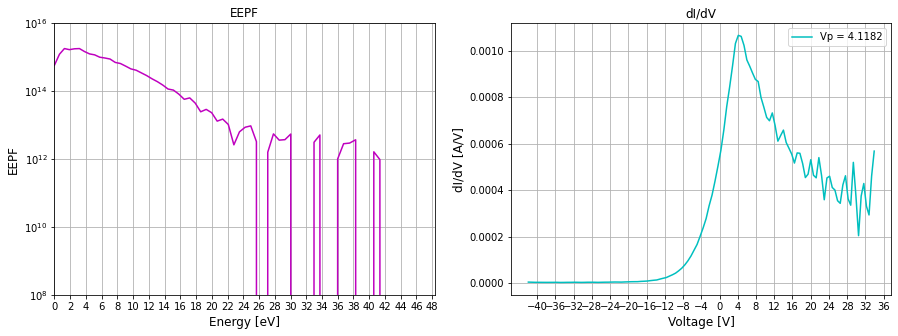

Enter limited energy
ne: 1.262e+16 [m-3]	 Te: 11.616 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.227	 gamma: 116.1568	 sol_number: 2
J: 9.30e+01	 uB: 626.796	 r_sh: 2.03e-04	
-------------------------------------------------------
a_0: 121.4790	 a_s: 0.0605	 gamma: 116.1568	 sol_number: 2
J: 4.58e+01	 uB: 1075.939	 r_sh: 2.48e-04	
-------------------------------------------------------
a_0: 34.1851	 a_s: 0.0797	 gamma: 116.1568	 sol_number: 2
J: 3.75e+01	 uB: 960.393	 r_sh: 2.58e-04	
-------------------------------------------------------
a_0: 31.2354	 a_s: 0.0815	 gamma: 116.1568	 sol_number: 2
J: 3.60e+01	 uB: 951.544	 r_sh: 2.61e-04	
-------------------------------------------------------
a_0: 30.2182	 a_s: 0.0822	 gamma: 116.1568	 sol_number: 2
J: 3.56e+01	 uB: 948.176	 r_sh: 2.62e-04	
-------------------------------------------------------
a_0: 30.0207	 a_s: 0.0823	 gamma: 116.1568	 sol_number: 2
J: 3.55e+01	 uB: 947.698	 r_sh: 2.62e-04	
------------------------------------------------

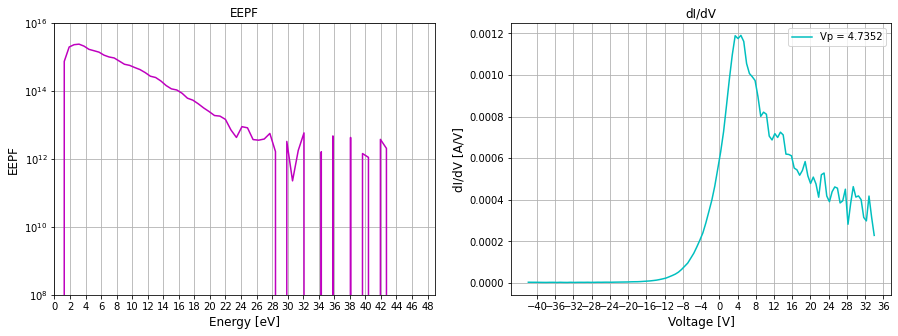

Enter limited energy
ne: 1.341e+16 [m-3]	 Te: 13.824 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2312	 gamma: 138.2363	 sol_number: 2
J: 9.78e+01	 uB: 624.137	 r_sh: 2.00e-04	
-------------------------------------------------------
a_0: 120.6708	 a_s: 0.0625	 gamma: 138.2363	 sol_number: 2
J: 4.88e+01	 uB: 1072.117	 r_sh: 2.44e-04	
-------------------------------------------------------
a_0: 34.3308	 a_s: 0.0816	 gamma: 138.2363	 sol_number: 2
J: 4.01e+01	 uB: 958.393	 r_sh: 2.54e-04	
-------------------------------------------------------
a_0: 31.4758	 a_s: 0.0834	 gamma: 138.2363	 sol_number: 2
J: 3.85e+01	 uB: 949.618	 r_sh: 2.56e-04	
-------------------------------------------------------
a_0: 30.4946	 a_s: 0.0841	 gamma: 138.2363	 sol_number: 2
J: 3.82e+01	 uB: 946.277	 r_sh: 2.57e-04	
-------------------------------------------------------
a_0: 30.3085	 a_s: 0.0842	 gamma: 138.2363	 sol_number: 2
J: 3.81e+01	 uB: 945.803	 r_sh: 2.57e-04	
-----------------------------------------------

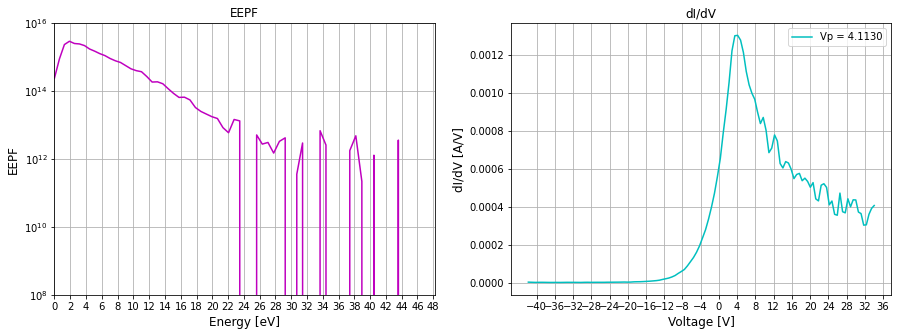

Enter limited energy
ne: 1.565e+16 [m-3]	 Te: 10.508 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2243	 gamma: 105.0839	 sol_number: 2
J: 1.01e+02	 uB: 628.502	 r_sh: 1.99e-04	
-------------------------------------------------------
a_0: 105.8264	 a_s: 0.0609	 gamma: 105.0839	 sol_number: 2
J: 5.07e+01	 uB: 1066.107	 r_sh: 2.41e-04	
-------------------------------------------------------
a_0: 30.6311	 a_s: 0.0806	 gamma: 105.0839	 sol_number: 2
J: 4.18e+01	 uB: 951.110	 r_sh: 2.51e-04	
-------------------------------------------------------
a_0: 28.2368	 a_s: 0.0823	 gamma: 105.0839	 sol_number: 2
J: 4.02e+01	 uB: 943.005	 r_sh: 2.53e-04	
-------------------------------------------------------
a_0: 27.3720	 a_s: 0.083	 gamma: 105.0839	 sol_number: 2
J: 3.98e+01	 uB: 939.735	 r_sh: 2.54e-04	
-------------------------------------------------------
a_0: 27.2145	 a_s: 0.0831	 gamma: 105.0839	 sol_number: 2
J: 3.98e+01	 uB: 939.271	 r_sh: 2.54e-04	
------------------------------------------------

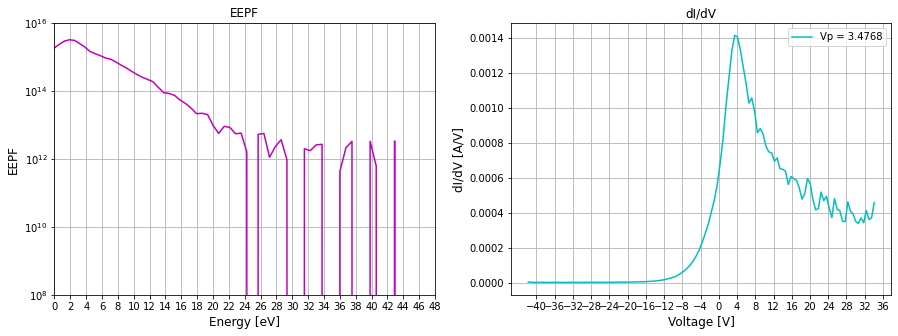

Enter limited energy
ne: 1.695e+16 [m-3]	 Te: 8.327 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2167	 gamma: 83.2680	 sol_number: 2
J: 1.04e+02	 uB: 633.504	 r_sh: 1.98e-04	
-------------------------------------------------------
a_0: 100.2424	 a_s: 0.0581	 gamma: 83.2680	 sol_number: 2
J: 5.28e+01	 uB: 1067.026	 r_sh: 2.39e-04	
-------------------------------------------------------
a_0: 29.4032	 a_s: 0.0777	 gamma: 83.2680	 sol_number: 2
J: 4.37e+01	 uB: 951.984	 r_sh: 2.48e-04	
-------------------------------------------------------
a_0: 27.1929	 a_s: 0.0793	 gamma: 83.2680	 sol_number: 2
J: 4.21e+01	 uB: 944.307	 r_sh: 2.50e-04	
-------------------------------------------------------
a_0: 26.3744	 a_s: 0.08	 gamma: 83.2680	 sol_number: 2
J: 4.17e+01	 uB: 941.013	 r_sh: 2.51e-04	
-------------------------------------------------------
a_0: 26.2297	 a_s: 0.0801	 gamma: 83.2680	 sol_number: 2
J: 4.16e+01	 uB: 940.546	 r_sh: 2.51e-04	
-------------------------------------------------------


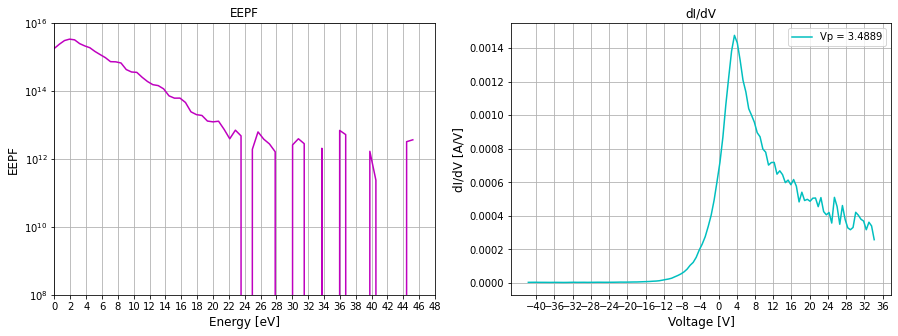

Enter limited energy
ne: 1.762e+16 [m-3]	 Te: 8.257 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2164	 gamma: 82.5729	 sol_number: 2
J: 1.06e+02	 uB: 633.702	 r_sh: 1.97e-04	
-------------------------------------------------------
a_0: 97.9461	 a_s: 0.0583	 gamma: 82.5729	 sol_number: 2
J: 5.38e+01	 uB: 1064.843	 r_sh: 2.38e-04	
-------------------------------------------------------
a_0: 28.8942	 a_s: 0.0779	 gamma: 82.5729	 sol_number: 2
J: 4.46e+01	 uB: 950.479	 r_sh: 2.47e-04	
-------------------------------------------------------
a_0: 26.7547	 a_s: 0.0795	 gamma: 82.5729	 sol_number: 2
J: 4.30e+01	 uB: 942.841	 r_sh: 2.49e-04	
-------------------------------------------------------
a_0: 25.9608	 a_s: 0.0802	 gamma: 82.5729	 sol_number: 2
J: 4.26e+01	 uB: 939.564	 r_sh: 2.49e-04	
-------------------------------------------------------
a_0: 25.8236	 a_s: 0.0803	 gamma: 82.5729	 sol_number: 2
J: 4.25e+01	 uB: 939.099	 r_sh: 2.49e-04	
-------------------------------------------------------

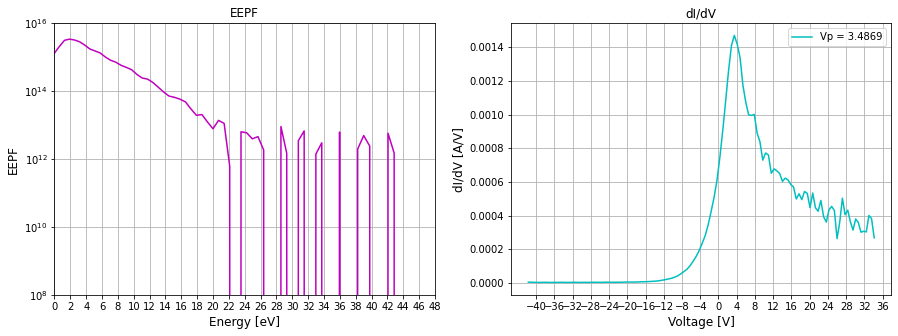

Enter limited energy
ne: 1.764e+16 [m-3]	 Te: 8.420 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2171	 gamma: 84.2048	 sol_number: 2
J: 1.07e+02	 uB: 633.240	 r_sh: 1.97e-04	
-------------------------------------------------------
a_0: 98.8496	 a_s: 0.0585	 gamma: 84.2048	 sol_number: 2
J: 5.45e+01	 uB: 1065.206	 r_sh: 2.37e-04	
-------------------------------------------------------
a_0: 29.1986	 a_s: 0.078	 gamma: 84.2048	 sol_number: 2
J: 4.52e+01	 uB: 951.235	 r_sh: 2.46e-04	
-------------------------------------------------------
a_0: 27.0467	 a_s: 0.0797	 gamma: 84.2048	 sol_number: 2
J: 4.35e+01	 uB: 943.107	 r_sh: 2.48e-04	
-------------------------------------------------------
a_0: 26.2662	 a_s: 0.0803	 gamma: 84.2048	 sol_number: 2
J: 4.32e+01	 uB: 940.294	 r_sh: 2.48e-04	
-------------------------------------------------------
a_0: 26.1164	 a_s: 0.0804	 gamma: 84.2048	 sol_number: 2
J: 4.31e+01	 uB: 939.828	 r_sh: 2.49e-04	
-------------------------------------------------------


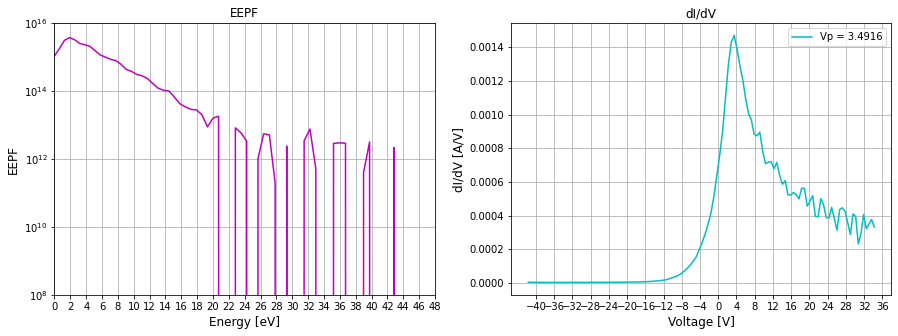

Enter limited energy
ne: 1.776e+16 [m-3]	 Te: 8.454 [eV] 	 V_lim: 20.0
a_0: 3.0000	 a_s: 0.2173	 gamma: 84.5418	 sol_number: 2
J: 1.08e+02	 uB: 633.081	 r_sh: 1.96e-04	
-------------------------------------------------------
a_0: 98.7430	 a_s: 0.0586	 gamma: 84.5418	 sol_number: 2
J: 5.49e+01	 uB: 1064.858	 r_sh: 2.37e-04	
-------------------------------------------------------
a_0: 29.2121	 a_s: 0.0781	 gamma: 84.5418	 sol_number: 2
J: 4.55e+01	 uB: 951.001	 r_sh: 2.45e-04	
-------------------------------------------------------
a_0: 27.0729	 a_s: 0.0797	 gamma: 84.5418	 sol_number: 2
J: 4.39e+01	 uB: 943.351	 r_sh: 2.47e-04	
-------------------------------------------------------
a_0: 26.2838	 a_s: 0.0804	 gamma: 84.5418	 sol_number: 2
J: 4.35e+01	 uB: 940.069	 r_sh: 2.48e-04	
-------------------------------------------------------
a_0: 26.1473	 a_s: 0.0805	 gamma: 84.5418	 sol_number: 2
J: 4.34e+01	 uB: 939.603	 r_sh: 2.48e-04	
-------------------------------------------------------

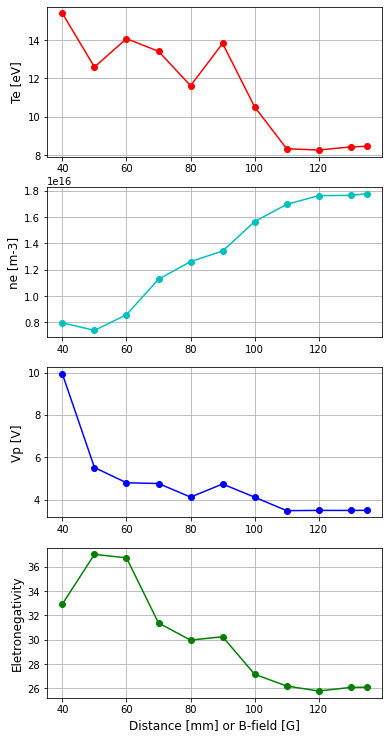

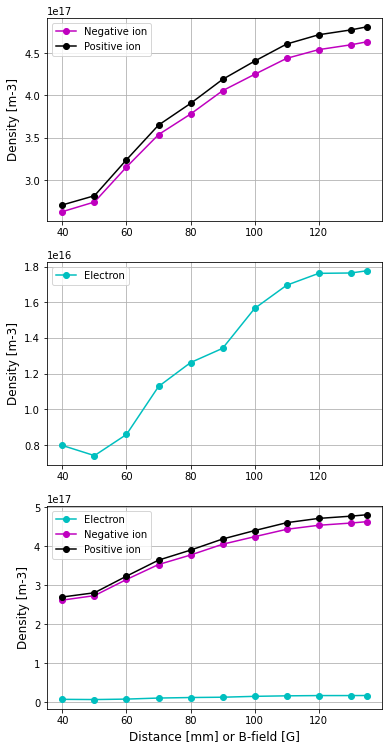

In [6]:
data_iter, data_fit = [], []

workDir = './211216(SF6)/bias (float) 56mm B-field/'
#workDir = './211221(SF6)/SF6/Radial Scan_15sccm/'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

for file in ldf_list:

    # Check file name
    print(file)


    # Parsing IV curve from ldf file
    IV, imported_eedf, result = parser.pull_attr(file, need_return=True)
    x = float(file.split('/')[-1][:-4])


    # Calculation x, Vsat, Isat, Vp, eepf, eedf, second_derivative from IV curve
    processor = ldf.processor(IV)
    Vsat, Isat = processor.cal_sat()
    Vp = processor.cal_Vp()
    energy, eepf, eedf = processor.cal_eepf()
    V, IV_second_derivative = processor.cal_second_derivative()


    # Plot EEPF and dIdV to determine energy range 
    plotting.plot_check(energy, eepf, processor.V, processor.dIdV, Vp)


    # Enter energy range for EEDF integration to get ne & Te
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)


    # Calculation ne & Te from EEDF
    ne = processor.cal_ne(V_lim)
    Te = processor.cal_Te(ne, V_lim)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV] \t V_lim: {}'.format(ne, Te, V_lim))
    

    # Start Iterative method
    iter_1 = method.iterative(ne, Te, Vsat, Isat, Vp)
    alpha_iter = iter_1.iteration()
    nm = ne*alpha_iter
    #print("Iteration method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    data_iter.append((Vp, alpha_iter, Te, x, ne, nm))


    # Start Fitting method
    # fit_1 = method.fitting(IV, V, IV_second_derivative)
    # alpha_fit = fit_1.fitting()
    # nm = ne*alpha_fit
    # #print("Fitting method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    # data_fit.append((Vp, alpha_fit, Te, x, ne, nm))


# Plot results
df_iter = pd.DataFrame(data_iter, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
plotting.plot_default(df_iter['x'], df_iter['Te'], df_iter['Vp'], df_iter['alpha'], df_iter['ne'])
plotting.plot_density(df_iter['x'], df_iter['ne'], df_iter['nm'])

# df_fit = pd.DataFrame(data_fit, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
# plotting.plot_default(df_fit['x'], df_fit['Te'], df_fit['Vp'], df_fit['alpha'], df_fit['ne'])
# plotting.plot_density(df_fit['x'], df_fit['ne'], df_fit['nm'])

0.05754026132188865


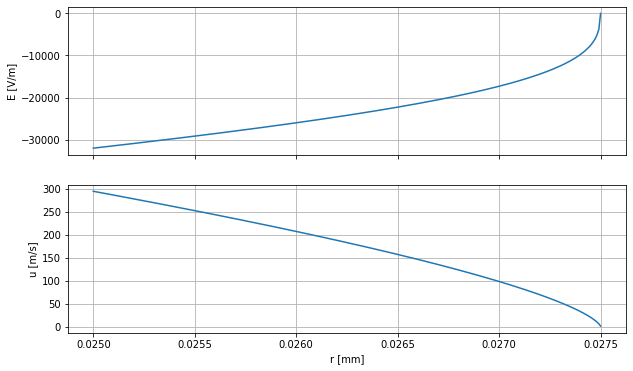

In [143]:
rp= 25e-6
J = 10
uB = 1
s = 0.1*25e-6

def cylindrical_sheath(s):
    R = rp + s
    r_list = np.linspace(R, rp, 300)
    def fun(y, r):
        return [R*J/(r*epsilon_0*y[1]) - y[0]/r, e*y[0]/(Mp*y[1])]

    sol = odeint(fun, y0=[0, uB], t=r_list)
    V = simpson(sol[:, 0], r_list)
    return sol[:, 0], sol[:, 1], V, r_list

def child_law(s):
    V = (9/4/epsilon_0*J*s**2*np.sqrt(Mp/2/e))**(2/3)
    return V

E, u, V, r_list = cylindrical_sheath(s)

plt.subplots(figsize=(10,6))
ax1 = plt.subplot(2,1,1)
plt.plot(r_list*1e3, E)
plt.ylabel('E [V/m]')
plt.xticks(visible=False)
plt.grid(True)

ax2 = plt.subplot(2,1,2,sharex=ax1)
plt.plot(r_list*1e3, u)
plt.ylabel('u [m/s]')
plt.xlabel('r [mm]')
plt.grid(True)
print(V)

In [146]:
s_list = np.linspace(0.01*rp, 10*rp, 200)
V_list = []
V_child_list = []

for s in s_list:
    V_list.append(cylindrical_sheath(s)[2])
    V_child_list.append(child_law(s))

V_list = np.array(V_list)
V_child_list = np.array(V_child_list)

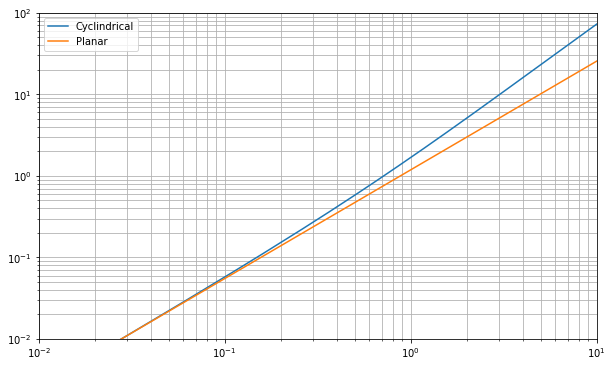

In [147]:
plt.figure(figsize=(10,6))
plt.plot((s_list)/rp, V_list)
plt.plot((s_list)/rp, V_child_list)

plt.legend(['Cyclindrical', 'Planar'])
plt.xscale('log')
plt.yscale('log')
plt.xticks()
plt.xlim(1e-2,1e1)
plt.ylim(1e-2,1e2)
plt.grid(True, 'both')